In [1]:
from custommodels.SpreadingModels import CascadeModel, ClassicalModel, ThresholdModel, SIRModelBase
from custommodels.Pickle import load
import networkx as nx
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
random.seed(1337)

In [2]:
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph())
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [3]:
sorted_degree = load('sorted_degree')
betweenness_centrality = load('betweenness_centrality')
sorted_betweenness = sorted(list(betweenness_centrality.items()), key=lambda x: x[1], reverse=True)
print([key for key,value in sorted_degree[:10]])
print([key for key, value in sorted_betweenness[:10]])
_n = 10

Found data, loading from picklejar
Found data, loading from picklejar
[40, 44, 108, 116, 159, 36, 191, 49, 634, 156]
[40, 191, 159, 108, 44, 36, 116, 35, 49, 405]


In [4]:
def disjoint_sets(n = None):
    n = n or _n

    sorted_betweenness_copy = deepcopy(sorted_betweenness)
    sorted_degree_copy = deepcopy(sorted_degree)
    top_n_deg = []
    top_n_bet = []
    while True:
        if len(top_n_deg) == n and len(top_n_bet) == n:
            break

        deg_candidate = sorted_degree_copy.pop(0)
        bet_candidate = sorted_betweenness_copy.pop(0)

        if str(deg_candidate[0]) == str(bet_candidate[0]):
            continue
        if str(deg_candidate[0]) not in top_n_bet and len(top_n_deg) < n:
            top_n_deg.append(str(deg_candidate[0]))
        if str(bet_candidate[0]) not in top_n_deg and len(top_n_bet) < n:
            top_n_bet.append(str(bet_candidate[0]))
    
    sorted_betweenness_copy = deepcopy(sorted_betweenness)
    sorted_degree_copy = deepcopy(sorted_degree)
    bot_n_deg = []
    bot_n_bet = []
    while True:
        if len(bot_n_deg) == n and len(bot_n_bet) == n:
            break

        deg_candidate = sorted_degree_copy.pop(-1)
        bet_candidate = sorted_betweenness_copy.pop(-1)
        if str(deg_candidate[0]) == str(bet_candidate[0]):
            continue
        if str(deg_candidate[0]) not in bot_n_bet and len(bot_n_deg) < n:
            bot_n_deg.append(str(deg_candidate[0]))
        if str(bet_candidate[0]) not in bot_n_deg and len(bot_n_bet) < n:
            bot_n_bet.append(str(bet_candidate[0]))
    
    return top_n_deg, top_n_bet, bot_n_deg, bot_n_bet

def betweenness_from_nodelist(nl):
    # Returns tuples (node, betweenness)
    return [(node, betweenness_centrality[int(node)]) for node in nl]
def degree_from_nodelist(nl):
    # Returns tuples (node, degree)
    return [(node, G.degree[node]) for node in nl]


In [5]:

top_n_deg, top_n_bet, bot_n_deg, bot_n_bet = disjoint_sets()
top_n_deg, bot_n_deg = degree_from_nodelist(top_n_deg), degree_from_nodelist(bot_n_deg)
top_n_bet, bot_n_bet = betweenness_from_nodelist(top_n_bet), betweenness_from_nodelist(bot_n_bet)
# print(top_n_deg)
# print(top_n_bet)
# print(bot_n_deg)
# print(bot_n_bet)
print(top_n_deg)
print(disjoint_sets()[0])


[('44', 1055), ('108', 854), ('116', 838), ('49', 569), ('634', 550), ('156', 475), ('207', 453), ('651', 448), ('3245', 404), ('250', 386)]
['44', '108', '116', '49', '634', '156', '207', '651', '3245', '250']


In [6]:
def get_starter_degreenodes(n = None):
    n = n or _n

    top_n_degree = [str(node) for node, _ in sorted_degree[:n]]
    bottom_n_degree = [str(node) for node, _ in sorted_degree[-n-1:-1]]
    return top_n_degree, bottom_n_degree

def get_starter_betweennodes(n = None):
    n = n or _n

    top_n_betweenness = [str(node) for node, _ in sorted_betweenness[:n]]
    bottom_n_betweenness = [str(node) for node, _ in sorted_betweenness[-n-1:-1]]
    return top_n_betweenness, bottom_n_betweenness

random_infect = deepcopy(list(G.nodes()))
random.shuffle(random_infect)

random_recovered = deepcopy(list(G.nodes()))
random.shuffle(random_recovered)

def get_starter_random(n=None):
    n = n or _n

    return random_infect[:n]
    

def get_recovered_random(n=None):
    n = n or _n

    return random_recovered[:n]

def results_to_noderatios(results, num_initial_infected, G):
    # results is a list of tuples (new_state: dict, newly_infected: list, newly_recovered: list)
    # this turns it into a list of lists, [susceptible: int[], infected: int[], recovered: int[]]
    # the 0th element in each list is the first step, the 1st element is the second step, etc.
    n = len(G.nodes)
    num_susceptible = [n - num_initial_infected]
    num_infected = [num_initial_infected]
    num_recovered = [0]
    for state, i, r in results:
        num_susceptible.append(list(state.values()).count(0))
        num_infected.append(list(state.values()).count(1))
        num_recovered.append(list(state.values()).count(2))
    return np.array(num_susceptible)/n, np.array(num_infected)/n, np.array(num_recovered)/n

# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet
print(random_infect)
print(random_recovered)


# un is for union
def undisjoint(n = None):
    n = n or _n

    # Get top n*2 degree nodes
    top_deg, bot_deg = get_starter_degreenodes(n*2)
    # Sort them by betweenness
    top_deg_bet = betweenness_from_nodelist(top_deg)
    bot_deg_bet = betweenness_from_nodelist(bot_deg)
    top_deg_bet.sort(key=lambda x: x[1], reverse=True)
    bot_deg_bet.sort(key=lambda x: x[1], reverse=False)
    # Get top n degree nodes
    top_deg_bet = [node for node, _ in top_deg_bet[:n]]
    bot_deg_bet = [node for node, _ in bot_deg_bet[:n]]
    
    return top_deg_bet, bot_deg_bet

['56705', '15709', '30437', '22251', '21395', '18235', '47927', '2409', '14580', '28888', '10285', '22538', '11334', '45231', '15940', '9856', '57646', '18140', '11674', '14280', '18203', '18560', '3861', '42424', '2131', '25505', '23820', '26951', '51852', '55477', '2060', '12204', '51703', '45795', '44772', '28904', '42219', '21951', '20878', '55023', '9584', '56706', '30515', '54100', '17031', '14211', '46545', '35965', '48219', '5539', '41432', '8181', '3889', '14740', '26711', '32763', '26183', '22190', '48510', '42817', '21194', '20978', '18506', '6484', '26010', '47451', '22900', '42572', '13713', '33169', '57641', '116', '7616', '42717', '8230', '33232', '17275', '56039', '18945', '41809', '43130', '13292', '43974', '53297', '17418', '14878', '36449', '35788', '46219', '23002', '10723', '56465', '27379', '30573', '56121', '47806', '9752', '50715', '17797', '37905', '36118', '19311', '26837', '40124', '26887', '21732', '35485', '42636', '7810', '28532', '8274', '18649', '34668',

In [7]:
def plot_three_graphs_degree(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False):
    if disjoint:
        top_degree, bottom_degree = disjoint_sets()[0], disjoint_sets()[2]
    else:
        top_degree, bottom_degree = get_starter_degreenodes()
    random = get_starter_random()

    top_degree_model    = deepcopy(model)
    bottom_degree_model = deepcopy(model)
    random_model        = deepcopy(model)

    top_degree_model.set_initial_infected(top_degree)
    bottom_degree_model.set_initial_infected(bottom_degree)
    random_model.set_initial_infected(random)

    top_degree_results    = results_to_noderatios(top_degree_model.iterate(iterations), len(top_degree), G)
    bottom_degree_results = results_to_noderatios(bottom_degree_model.iterate(iterations), len(bottom_degree), G)
    random_results        = results_to_noderatios(random_model.iterate(iterations), len(random), G)
    
    model_results = (top_degree_results, bottom_degree_results, random_results)
    model_names   = (f'Top {len(top_degree)} Degree', f'Bottom {len(bottom_degree)} Degree', f'{len(random)} Random')
    model_colors  = ('red', 'green', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Infected", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()
    return top_degree_results, bottom_degree_results, random_results

# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet

In [8]:
def plot_three_graphs_between(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False):
    if disjoint:
        top_between, bottom_between = disjoint_sets()[1], disjoint_sets()[3]
    else:
        top_between, bottom_between = get_starter_betweennodes()
    random = get_starter_random()

    top_between_model    = deepcopy(model)
    bottom_between_model = deepcopy(model)
    random_model         = deepcopy(model)

    top_between_model.set_initial_infected(top_between)
    bottom_between_model.set_initial_infected(bottom_between)
    random_model.set_initial_infected(random)

    top_between_results    = results_to_noderatios(top_between_model.iterate(iterations), len(top_between), G)
    bottom_between_results = results_to_noderatios(bottom_between_model.iterate(iterations), len(bottom_between), G)
    random_results         = results_to_noderatios(random_model.iterate(iterations), len(random), G)
    
    model_results = (top_between_results, bottom_between_results, random_results)
    model_names   = (f'Top {len(top_between)} Betweenness centrality', f'Bottom {len(bottom_between)} Betweenness centrality', f'{len(random)} Random')
    model_colors  = ('red', 'green', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Infected", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

    return top_between_results, bottom_between_results, random_results

## Immunitization 

In [9]:
# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet
def plot_immune(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False, n_vaccinated=None):
    n_vaccinated = n_vaccinated or _n

    if disjoint:
        top_degree, top_between, bottom_degree, bottom_between = disjoint_sets(n_vaccinated)
    else:
        top_between, bottom_between = get_starter_betweennodes(n_vaccinated)
        top_degree, bottom_degree = get_starter_degreenodes(n_vaccinated)
    # random nodes to infect
    random_infect = get_starter_random()
    # random nodes to recover 
    random_immune = get_recovered_random(n_vaccinated)

    top_between_recovered = deepcopy(model)
    top_degree_recovered = deepcopy(model)
    random_model = deepcopy(model)
    no_immune = deepcopy(model)

    random_model.set_initial_infected(random_infect)
    top_between_recovered.set_initial_infected(random_infect)
    top_degree_recovered.set_initial_infected(random_infect)
    no_immune.set_initial_infected(random_infect)

    top_between_recovered.set_initial_recovered(top_between)
    top_degree_recovered.set_initial_recovered(top_degree)
    random_model.set_initial_recovered(random_immune)



    random_results = results_to_noderatios(random_model.iterate(iterations), len(random_infect), G)
    top_between_results    = results_to_noderatios(top_between_recovered.iterate(iterations), len(random_infect), G)
    top_degree_results = results_to_noderatios(top_degree_recovered.iterate(iterations), len(random_infect), G)
    no_immune_results = results_to_noderatios(no_immune.iterate(iterations), len(random_infect), G)

    model_results = (top_between_results, top_degree_results, random_results, no_immune_results)

    model_names   = (f'Top {len(top_between)} Betweenness centrality', f'Top {len(top_degree)} Degree', f'{len(random_immune)} Random', 'No immunity')
    model_colors  = ('red', 'green', 'blue', 'black') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Immune", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

    return top_between_results, top_degree_results, random_results


In [10]:
# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet
def plot_immune_undisjoint(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, n_vaccinated=None):
    n_vaccinated = n_vaccinated or _n
    top_degbet, bot_degbet = undisjoint(n_vaccinated)


    # random nodes to infect
    random_infect = get_starter_random()
    # random nodes to recover 
    random_immune = get_recovered_random(n_vaccinated)

    top_detbet_recovered = deepcopy(model)
    random_model = deepcopy(model)

    random_model.set_initial_infected(random_infect)
    top_detbet_recovered.set_initial_infected(random_infect)

    top_detbet_recovered.set_initial_recovered(top_degbet)
    random_model.set_initial_recovered(random_immune)



    random_results = results_to_noderatios(random_model.iterate(iterations), len(random_infect), G)
    top_detbet_results    = results_to_noderatios(top_detbet_recovered.iterate(iterations), len(random_infect), G)

    model_results = (top_detbet_results, random_results)

    model_names   = (f'Top {len(top_degbet)} Degree and Betweenness centrality', f'{len(random_immune)} Random')
    model_colors  = ('red', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Immune", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

    return top_detbet_results, random_results


# Cascade

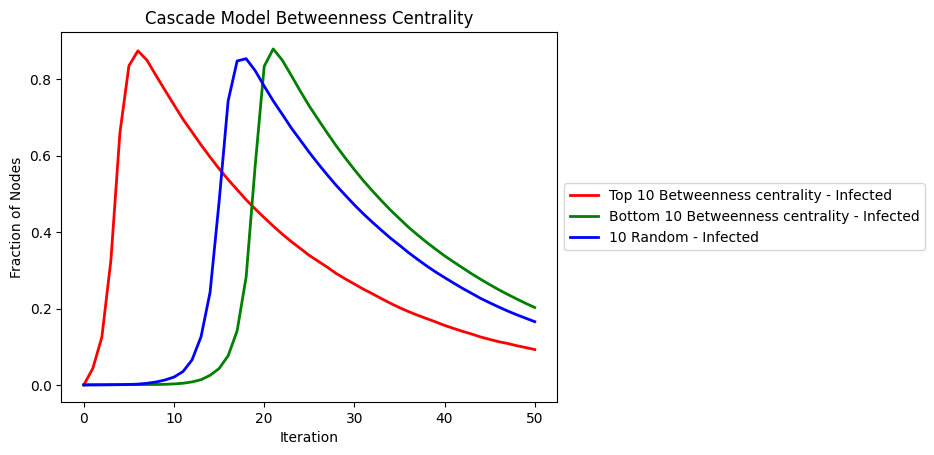

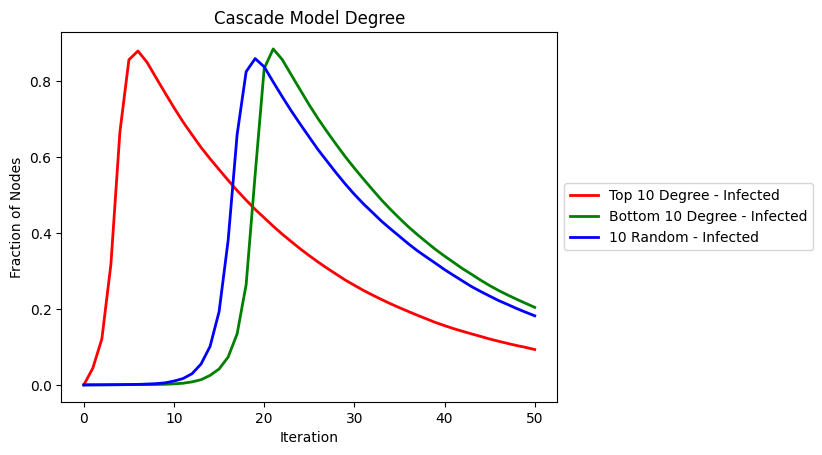

In [30]:
def cascade_plot():
    model_between = CascadeModel(G)
    beta, gamma = 0.1, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd = plot_three_graphs_between(
        model_between, 
        title='Cascade Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        # recovered=False
    )

    model_degree = CascadeModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Cascade Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )

    return betw_top, betw_bot, betw_rnd, degr_top, degr_bot, degr_rnd
cascade_betw_top, cascade_betw_bot, cascade_betw_rnd, cascade_degr_top, cascade_degr_bot, cascade_degr_rnd = cascade_plot()

In [31]:
cascade_max_topdegree, cascade_time_step_topdegree = max(cascade_degr_top[1]), np.argmax(cascade_degr_top[1])
cascade_max_bottomdegree, cascade_time_step_bottomdegree = max(cascade_degr_bot[1]), np.argmax(cascade_degr_bot[1])

cascade_max_topbetween, cascade_time_step_topbetween = max(cascade_betw_top[1]), np.argmax(cascade_betw_top[1])
cascade_max_bottombetween, time_step_bottombetween = max(cascade_betw_bot[1]), np.argmax(cascade_betw_bot[1])

cascade_max_random, cascade_time_step_random = max(cascade_betw_rnd[1]), np.argmax(cascade_betw_rnd[1])

print('Top degree:',cascade_max_topdegree, cascade_time_step_topdegree)
print('Bottom degree:',cascade_max_bottomdegree, cascade_time_step_bottomdegree)
print('Top betweenness:',cascade_max_topbetween, cascade_time_step_topbetween)
print('Bottom betweenness:',cascade_max_bottombetween, time_step_bottombetween)
print('Random:',cascade_max_random, cascade_time_step_random)




Top degree: 0.87911313206084 6
Bottom degree: 0.8845943707150284 21
Top betweenness: 0.8742663776238566 6
Bottom betweenness: 0.8792717531151413 21
Random: 0.8537337633726361 18


# Threshold

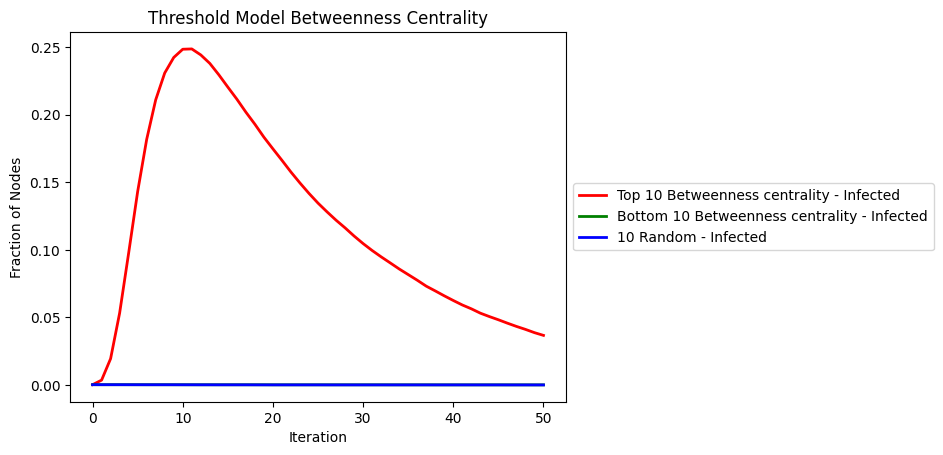

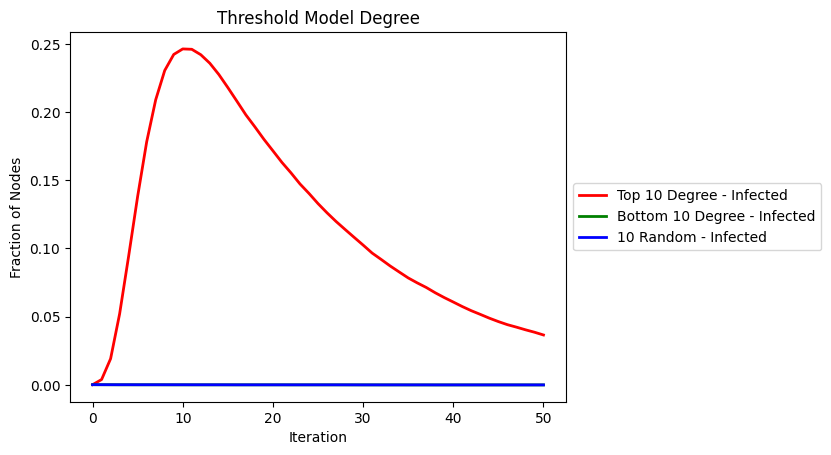

In [32]:
def threshold_plot():
    model_between = ThresholdModel(G)
    theta, beta, gamma = 3, 0.4, 0.05
    model_between.set_parameters(theta, beta, gamma)

    betw_top, betw_bot, betw_rnd = plot_three_graphs_between(
        model_between, 
        title='Threshold Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=False
    )

    model_degree = ThresholdModel(G)
    model_degree.set_parameters(theta, beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Threshold Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd
threshold_betw_top, threshold_betw_bot, threshold_betw_rnd, threshold_degr_top, threshold_degr_bot, threshold_degr_rnd = threshold_plot()

In [33]:
threshold_max_topdegree, threshold_time_step_topdegree = max(threshold_degr_top[1]), np.argmax(threshold_degr_top[1])
threshold_max_bottomdegree, threshold_time_step_bottomdegree = max(threshold_degr_bot[1]), np.argmax(threshold_degr_bot[1])

threshold_max_topbetween, threshold_time_step_topbetween = max(threshold_betw_top[1]), np.argmax(threshold_betw_top[1])
threshold_max_bottombetween, time_step_bottombetween = max(threshold_betw_bot[1]), np.argmax(threshold_betw_bot[1])

threshold_max_random, threshold_time_step_random = max(threshold_betw_rnd[1]), np.argmax(threshold_betw_rnd[1])

print('Top degree:',threshold_max_topdegree, threshold_time_step_topdegree)
print('Bottom degree:',threshold_max_bottomdegree, threshold_time_step_bottomdegree)
print('Top betweenness:',threshold_max_topbetween, threshold_time_step_topbetween)
print('Bottom betweenness:',threshold_max_bottombetween, time_step_bottombetween)
print('Random:',threshold_max_random, threshold_time_step_random)

Top degree: 0.24866493945963095 11
Bottom degree: 0.00017624561589030472 0
Top betweenness: 0.24628562364511183 10
Bottom betweenness: 0.00017624561589030472 0
Random: 0.00017624561589030472 0


# Classical 

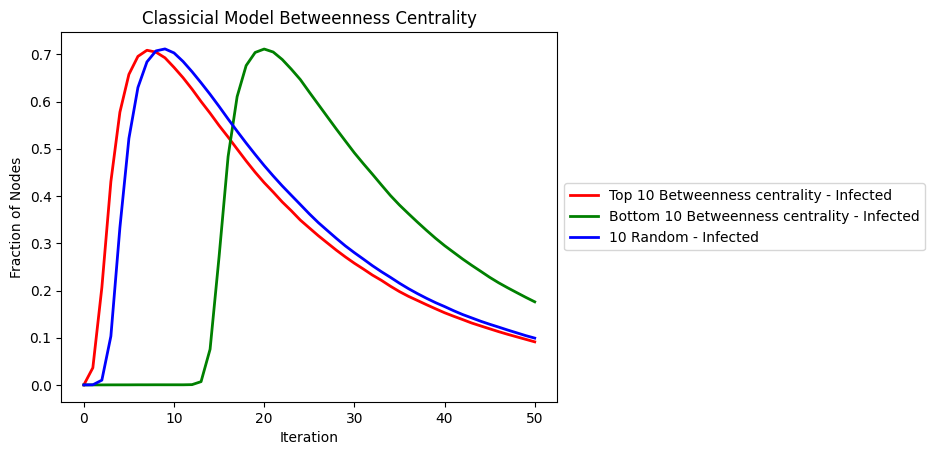

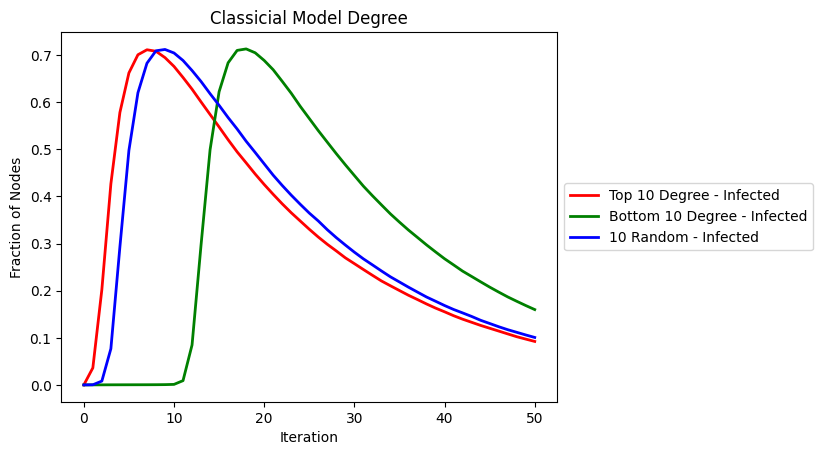

In [34]:
def classical_plot():
    model_between = ClassicalModel(G)
    beta, gamma = 0.3, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd= plot_three_graphs_between(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        # recovered=False
    )

    model_degree = ClassicalModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Classicial Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd

classical_betw_top, classical_betw_bot, classical_betw_rnd, classical_degr_top, classical_degr_bot, classical_degr_rnd = classical_plot()

In [35]:
classical_max_topdegree, classical_time_step_topdegree = max(classical_degr_top[1]), np.argmax(classical_degr_top[1])
classical_max_bottomdegree, classical_time_step_bottomdegree = max(classical_degr_bot[1]), np.argmax(classical_degr_bot[1])

classical_max_topbetween, classical_time_step_topbetween = max(classical_betw_top[1]), np.argmax(classical_betw_top[1])
classical_max_bottombetween, time_step_bottombetween = max(classical_betw_bot[1]), np.argmax(classical_betw_bot[1])

classical_max_random, classical_time_step_random = max(classical_betw_rnd[1]), np.argmax(classical_betw_rnd[1])

print('Top degree:',classical_max_topdegree, classical_time_step_topdegree)
print('Bottom degree:',classical_max_bottomdegree, classical_time_step_bottomdegree)
print('Top betweenness:',classical_max_topbetween, classical_time_step_topbetween)
print('Bottom betweenness:',classical_max_bottombetween, time_step_bottombetween)
print('Random:',classical_max_random, classical_time_step_random)

Top degree: 0.7085250004406141 7
Bottom degree: 0.7110981864326125 20
Top betweenness: 0.7112391829253247 7
Bottom betweenness: 0.7130192636458168 18
Random: 0.7118736671425299 9


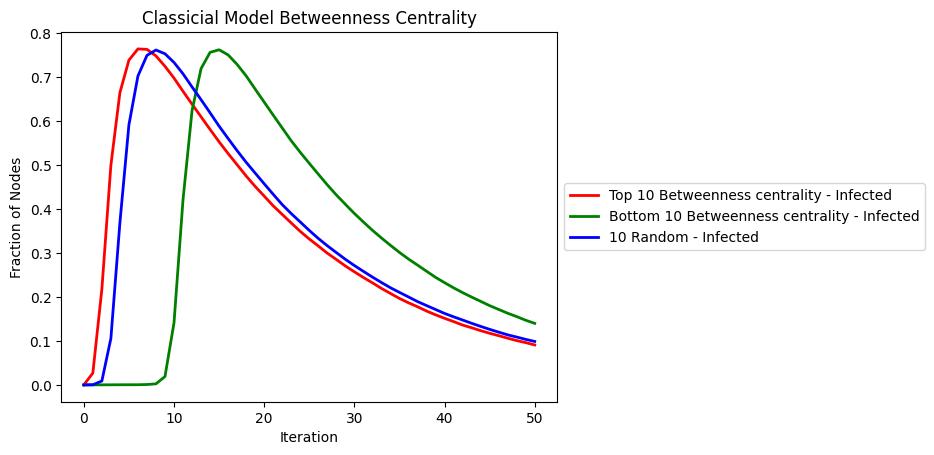

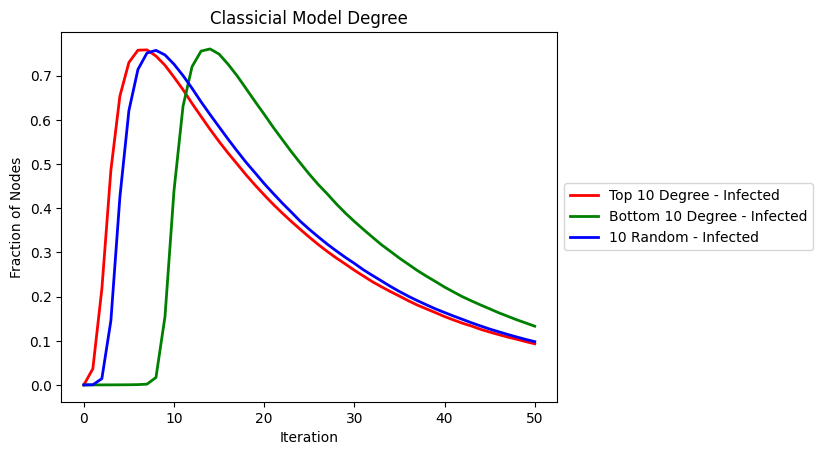

In [36]:
def classical_plot_disjoint():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd= plot_three_graphs_between(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        disjoint=True
    )

    model_degree = ClassicalModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Classicial Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        #recovered=True,
        disjoint = True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd

classical_betw_top_disjoint, classical_betw_bot_disjoint, classical_betw_rnd_disjoint, classical_degr_top_disjoint, classical_degr_bot_disjoint, classical_degr_rnd_disjoint = classical_plot_disjoint()

In [37]:
classical_max_topdegree_disjoint, classical_time_step_topdegree_disjoint = max(classical_degr_top_disjoint[1]), np.argmax(classical_degr_top_disjoint[1])
classical_max_bottomdegree_disjoint, classical_time_step_bottomdegree_disjoint = max(classical_degr_bot_disjoint[1]), np.argmax(classical_degr_bot_disjoint[1])

classical_max_topbetween_disjoint, classical_time_step_topbetween_disjoint = max(classical_betw_top_disjoint[1]), np.argmax(classical_betw_top_disjoint[1])
classical_max_bottombetween_disjoint, time_step_bottombetween_disjoint = max(classical_betw_bot_disjoint[1]), np.argmax(classical_betw_bot_disjoint[1])

classical_max_random_disjoint, classical_time_step_random_disjoint = max(classical_betw_rnd_disjoint[1]), np.argmax(classical_betw_rnd_disjoint[1])

print('Top degree:',classical_max_topdegree_disjoint, classical_time_step_topdegree_disjoint)
print('Bottom degree:',classical_max_bottomdegree_disjoint, classical_time_step_bottomdegree_disjoint)
print('Top betweenness:',classical_max_topbetween_disjoint, classical_time_step_topbetween_disjoint)
print('Bottom betweenness:',classical_max_bottombetween_disjoint, time_step_bottombetween_disjoint)
print('Random:',classical_max_random_disjoint, classical_time_step_random_disjoint)

Top degree: 0.764059994007649 6
Bottom degree: 0.7621565413560337 15
Top betweenness: 0.7585611307918716 7
Bottom betweenness: 0.7607113273057333 14
Random: 0.7574860325349407 8


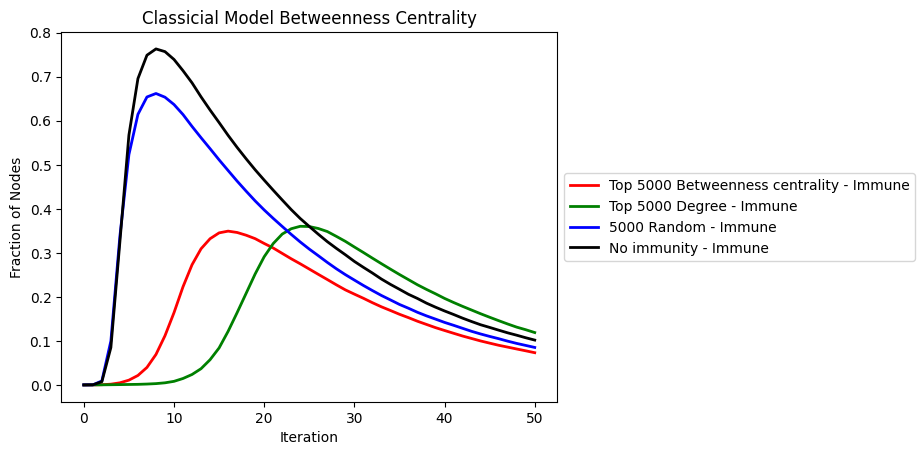

In [72]:
def classical_plot_recovered():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    top_between_results, top_degree_results, random_results= plot_immune(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        #disjoint=True
        n_vaccinated= 5000
    )

    return top_between_results, top_degree_results, random_results
classical_top_between_results_R, classical_top_degree_results_R, random_results_R = classical_plot_recovered()

In [65]:
max_degree_recovered, time_degree_recovered= max(classical_top_degree_results_R[1]), np.argmax(classical_top_degree_results_R[1])
max_between_recovered, time_between_recovered= max(classical_top_between_results_R[1]), np.argmax(classical_top_between_results_R[1])
max_random_recovered, time_random_recovered= max(random_results_R[1]), np.argmax(random_results_R[1])

print('Top 10 degree', max_degree_recovered, time_degree_recovered)
print('Top 10 between', max_between_recovered, time_between_recovered)
print('No immunitization', max_random_recovered, time_random_recovered)



Top 10 degree 0.6879042633814484 10
Top 10 between 0.6746153439433195 10
No immunitization 0.7536438781085321 8


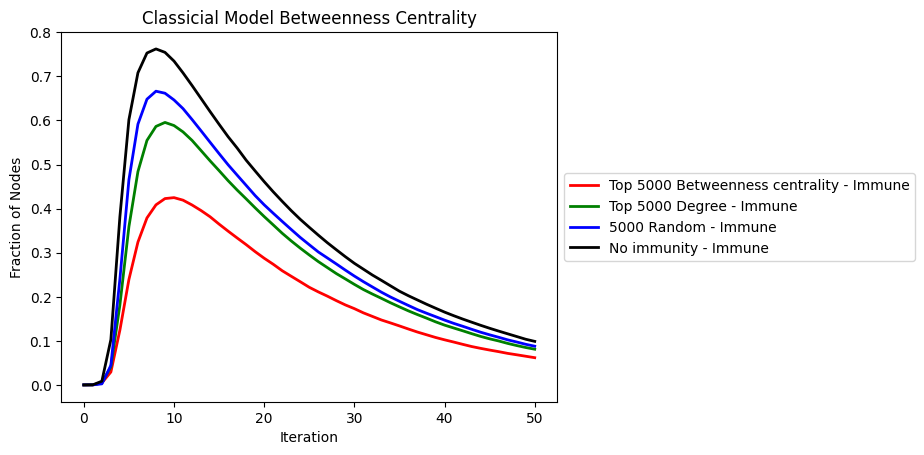

In [11]:
def classical_plot_recovered():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    top_between_results, top_degree_results, random_results= plot_immune(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        disjoint=True,
        n_vaccinated= 5000
    )

    return top_between_results, top_degree_results, random_results
top_between_results, top_degree_results, random_results = classical_plot_recovered()

In [20]:
n = len(G.nodes)
susceptible_between = top_between_results[0]
susceptible_degree = top_degree_results[0]
inf_bet = 1- susceptible_between[-1] - 5000/n
inf_deg = 1 - susceptible_degree[-1] - 5000/n
print('between infected:', inf_bet)
print('degree infected:', inf_deg)
print(n)

between infected: 0.571423535839546
degree infected: 0.7725021590087946
56739


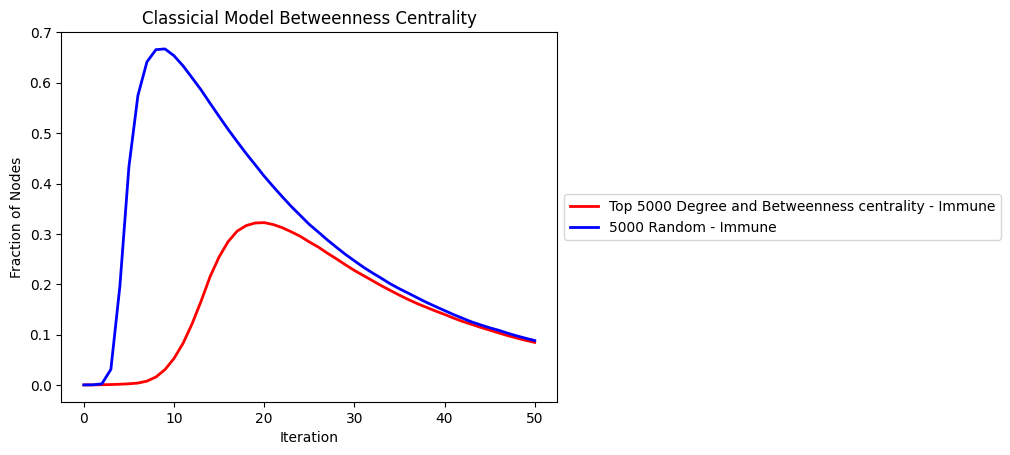

In [17]:
def classical_plot_recovered_un():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    top_degbet_results, random_results= plot_immune_undisjoint(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        n_vaccinated= 5000
    )

    return top_degbet_results, random_results
top_degbet_results_UN, random_results_UN = classical_plot_recovered_un()

In [19]:
susceptible_joint = top_degbet_results_UN[0]
inf_joint = 1- susceptible_joint[-1] - 5000/n

print('joint infected:', inf_joint)


joint infected: 0.5736089814765858
